# Summary

#### Aim:
The aim of this investigation is to explore the factors influencing playoff qualification in Major League Baseball (MLB) by addressing the following questions:

1. How many games must a team win to qualify for the playoffs?

2. What run differential (runs scored minus runs allowed) is needed to achieve this win threshold?

3. What factors contribute to a team achieving the required run differential?

#### Data:
- **Source:** [Kaggle](https://www.kaggle.com/datasets/wduckett/moneyball-mlb-stats-19622012/data).  
- **Dataset:** baseball.csv - Contains a set of baseball statistics from 1962 to 2012. The dataset contains 15 features and 1232 samples. There are some missing values.

#### Method:
Exploratory Data Analysis (EDA) was performed to understand the dataset and identify key patterns. Two features were dropped to avoid data leakage.

A logistic regression model was used to predict the number of wins required for a team to qualify for the playoffs. Given the imbalanced target variable (1:4 playoff vs. non-playoff teams), appropriate techniques were applied to account for this imbalance when fitting the model.

A univariate linear regression model was then used to predict the required run differential (runs scored minus runs allowed) needed to achieve the win threshold identified by the logistic model.

Finally, a multivariate linear regression model was employed to analyze the relationship between run differential and other team statistics in the dataset. 

#### Results and findings:
1. The logistic regression model achieved an F1 score of 0.79 for playoff teams (class 1) and an overall accuracy of 0.89. The model performed significantly better at predicting teams that missed the playoffs than those that qualified.

    To improve performance, the optimal decision threshold was determined, rather than relying on the default 0.5 cutoff.

    Based on the model’s predictions, a team must win at least 88 games in a 162-game season to have a reasonable chance of making the playoffs.

2. The univariate linear regression model achieved an R squared score of 0.87 on training data and 0.89 on test data, indicating a strong fit.

    The Mean Squared Error (MSE) was 18.1, corresponding to an average prediction error of approximately 4.25 games. The residuals were randomly distributed.

    According to the model, a team needs a run differential of about 69 to win 88 games. However, when compared with actual data, a run differential closer to 100 appears to provide a stronger likelihood of making the playoffs.

3. The multivariate regression model achieved an R squared score of 0.41 on both training and test data, indicating poor predictive performance. The Mean Squared Error (MSE) was 7371, corresponding to an average error of 86 runs.

    Multicollinearity was likely an issue due to high correlation among features. An optimal feature selection algorithm was applied, but it only led to the removal of one out of five features and did not improve the R squared score.

    Additionally, three of the four remaining features contained outliers, which may have further impacted model performance.

    The features with the greatest influence on run differential were OBP and OOBP. However, due to the model’s poor overall performance, these results should be interpreted with caution.

 
#### Future improvements or considerations:

Investigate the performance of other classification models for predicting playoffs, like Naive Bayes or SVM. Collecting interleague and intra-division data to add as features could enhance the predicting power of these models.

While feature selection helped reduce the number of features of the multivariate linear regression, multicollinearity may have still affected the model’s performance. Future iterations could involve using regularization techniques such as Ridge or Lasso regression to penalize highly correlated features and improve model stability.

Also, since three of the remaining features contained outliers, robust scaling or outlier detection methods could be applied to mitigate their impact. Alternatively, using adequate transformations could help stabilize the variance of features.

Enhancing the dataset’s quality by collecting more granular data (e.g., advanced team metrics, player-level statistics) could improve the various models' performance by providing more relevant information for predictions.

#### Data Dictionary:
- Team
- League
- Year
- Runs Scored (RS)
- Runs Allowed (RA)
- Wins (W)
- On-Base Percentage (OBP): measures how often a batter reaches base per plate appearance.
- Slugging Percentage (SLG): measures the power of a hitter by calculating the total number of bases they earn per at-bat.
- Batting Average (BA): measures how often a player gets a hit per at-bat.
- Playoffs (binary): whether a team made it to playoffs (made it = 1, didn't make it = 0).
- RankSeason
- RankPlayoffs
- Games Played (G)
- Opponent On-Base Percentage (OOBP): measures how often opposing batters reach base against a pitcher or team.
- Opponent Slugging Percentage (OSLG): measures how much power opposing hitters generate against a pitcher or team.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Part 1. Loading data and EDA

In [2]:
# Load the data

df = pd.read_csv('baseball.csv')
df.head()


,Team,League,Year,RS,RA,W,OBP,SLG,BA,Playoffs,RankSeason,RankPlayoffs,G,OOBP,OSLG
0,ARI,NL,2012,734,688,81,0.328,0.418,0.259,0,NaN,NaN,162,0.317,0.415
1,ATL,NL,2012,700,600,94,0.320,0.389,0.247,1,4.0,5.0,162,0.306,0.378
2,BAL,AL,2012,712,705,93,0.311,0.417,0.247,1,5.0,4.0,162,0.315,0.403
3,BOS,AL,2012,734,806,69,0.315,0.415,0.260,0,NaN,NaN,162,0.331,0.428
4,CHC,NL,2012,613,759,61,0.302,0.378,0.240,0,NaN,NaN,162,0.335,0.424


In [3]:
df.tail()

,Team,League,Year,RS,RA,W,OBP,SLG,BA,Playoffs,RankSeason,RankPlayoffs,G,OOBP,OSLG
1227,PHI,NL,1962,705,759,81,0.330,0.390,0.260,0,NaN,NaN,161,NaN,NaN
1228,PIT,NL,1962,706,626,93,0.321,0.394,0.268,0,NaN,NaN,161,NaN,NaN
1229,SFG,NL,1962,878,690,103,0.341,0.441,0.278,1,1.0,2.0,165,NaN,NaN
1230,STL,NL,1962,774,664,84,0.335,0.394,0.271,0,NaN,NaN,163,NaN,NaN
1231,WSA,AL,1962,599,716,60,0.308,0.373,0.250,0,NaN,NaN,162,NaN,NaN


In [4]:
df.isnull().sum()


Team              0
League            0
Year              0
RS                0
RA                0
W                 0
OBP               0
SLG               0
BA                0
Playoffs          0
RankSeason      988
RankPlayoffs    988
G                 0
OOBP            812
OSLG            812
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1232 entries, 0 to 1231
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Team          1232 non-null   object 
 1   League        1232 non-null   object 
 2   Year          1232 non-null   int64  
 3   RS            1232 non-null   int64  
 4   RA            1232 non-null   int64  
 5   W             1232 non-null   int64  
 6   OBP           1232 non-null   float64
 7   SLG           1232 non-null   float64
 8   BA            1232 non-null   float64
 9   Playoffs      1232 non-null   int64  
 10  RankSeason    244 non-null    float64
 11  RankPlayoffs  244 non-null    float64
 12  G             1232 non-null   int64  
 13  OOBP          420 non-null    float64
 14  OSLG          420 non-null    float64
dtypes: float64(7), int64(6), object(2)
memory usage: 144.5+ KB


In [6]:
df.shape

(1232, 15)

In [7]:
df.describe()

,Year,RS,RA,W,OBP,SLG,BA,Playoffs,RankSeason,RankPlayoffs,G,OOBP,OSLG
count,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,244.000000,244.000000,1232.000000,420.000000,420.000000
mean,1988.957792,715.081981,715.081981,80.904221,0.326331,0.397342,0.259273,0.198052,3.122951,2.717213,161.918831,0.332264,0.419743
std,14.819625,91.534294,93.079933,11.458139,0.015013,0.033267,0.012907,0.398693,1.738349,1.095234,0.624365,0.015295,0.026510
min,1962.000000,463.000000,472.000000,40.000000,0.277000,0.301000,0.214000,0.000000,1.000000,1.000000,158.000000,0.294000,0.346000
25%,1976.750000,652.000000,649.750000,73.000000,0.317000,0.375000,0.251000,0.000000,2.000000,2.000000,162.000000,0.321000,0.401000
50%,1989.000000,711.000000,709.000000,81.000000,0.326000,0.396000,0.260000,0.000000,3.000000,3.000000,162.000000,0.331000,0.419000
75%,2002.000000,775.000000,774.250000,89.000000,0.337000,0.421000,0.268000,0.000000,4.000000,4.000000,162.000000,0.343000,0.438000
max,2012.000000,1009.000000,1103.000000,116.000000,0.373000,0.491000,0.294000,1.000000,8.000000,5.000000,165.000000,0.384000,0.499000


In [8]:
df["Playoffs"].value_counts() # how many teams made the playoffs

Playoffs
0    988
1    244
Name: count, dtype: int64

In [9]:
df["Team"].value_counts() # how many samples per team

Team
HOU    47
DET    47
NYY    47
NYM    47
MIN    47
LAD    47
SFG    47
PIT    47
PHI    47
STL    47
CLE    47
CIN    47
CHW    47
CHC    47
BOS    47
BAL    47
ATL    43
OAK    41
KCR    40
SDP    40
MIL    39
TEX    37
TOR    33
SEA    33
MON    32
CAL    28
COL    18
FLA    17
ARI    15
LAA    11
TBD    10
WSA    10
WSN     8
ANA     8
KCA     6
TBR     5
MLN     4
MIA     1
SEP     1
Name: count, dtype: int64

In [10]:
# Count the number of unique teams

print(f"Number of unique teams: {df["Team"].nunique()}")

Number of unique teams: 39


In [11]:
df["League"].value_counts() # Count how many samples per league

League
NL    616
AL    616
Name: count, dtype: int64

In [12]:
# Count the occurrences of each year and sort by the year values in descending order
year_counts = df["Year"].value_counts(ascending=False).sort_index(ascending=False)

# Print the result
print(year_counts)

Year
2012    30
2011    30
2010    30
2009    30
2008    30
2007    30
2006    30
2005    30
2004    30
2003    30
2002    30
2001    30
2000    30
1999    30
1998    30
1997    28
1996    28
1993    28
1992    26
1991    26
1990    26
1989    26
1988    26
1987    26
1986    26
1985    26
1984    26
1983    26
1982    26
1980    26
1979    26
1978    26
1977    26
1976    24
1975    24
1974    24
1973    24
1971    24
1970    24
1969    24
1968    20
1967    20
1966    20
1965    20
1964    20
1963    20
1962    20
Name: count, dtype: int64


In [13]:
# Group by 'Year' and 'Playoffs' and count the number of teams
playoff_counts = df.groupby(['Year', 'Playoffs']).size().reset_index(name='Team Count')

# .reset_index() converts the Series to a DataFrame and names the count column 'Team Count'

# Set pandas to display all rows
pd.set_option('display.max_rows', 100)  # Set to a value >= 93

# Display the result
print(playoff_counts)

    Year  Playoffs  Team Count
0   1962         0          18
1   1962         1           2
2   1963         0          18
3   1963         1           2
4   1964         0          18
5   1964         1           2
6   1965         0          18
7   1965         1           2
8   1966         0          18
9   1966         1           2
10  1967         0          18
11  1967         1           2
12  1968         0          18
13  1968         1           2
14  1969         0          20
15  1969         1           4
16  1970         0          20
17  1970         1           4
18  1971         0          20
19  1971         1           4
20  1973         0          20
21  1973         1           4
22  1974         0          20
23  1974         1           4
24  1975         0          20
25  1975         1           4
26  1976         0          20
27  1976         1           4
28  1977         0          22
29  1977         1           4
30  1978         0          22
31  1978

In [14]:
# Investigating why are there 812 NaN values in the OOBP and OSLG columns

# Filter rows where OOBP and OSLG are NaN
missing_oobp_oslg = df[df['OOBP'].isna() & df['OSLG'].isna()]

print('Total rows missing both OOBP and OSLG:', len(missing_oobp_oslg))

# Get the unique years for which OOBP and OSLG are NaN
years_with_missing = missing_oobp_oslg['Year'].unique()

# Print the result
print(f"Years with NaN values in OOBP and OSLG: {years_with_missing}")

Total rows missing both OOBP and OSLG: 812
Years with NaN values in OOBP and OSLG: [1998 1997 1996 1993 1992 1991 1990 1989 1988 1987 1986 1985 1984 1983
 1982 1980 1979 1978 1977 1976 1975 1974 1973 1971 1970 1969 1968 1967
 1966 1965 1964 1963 1962]


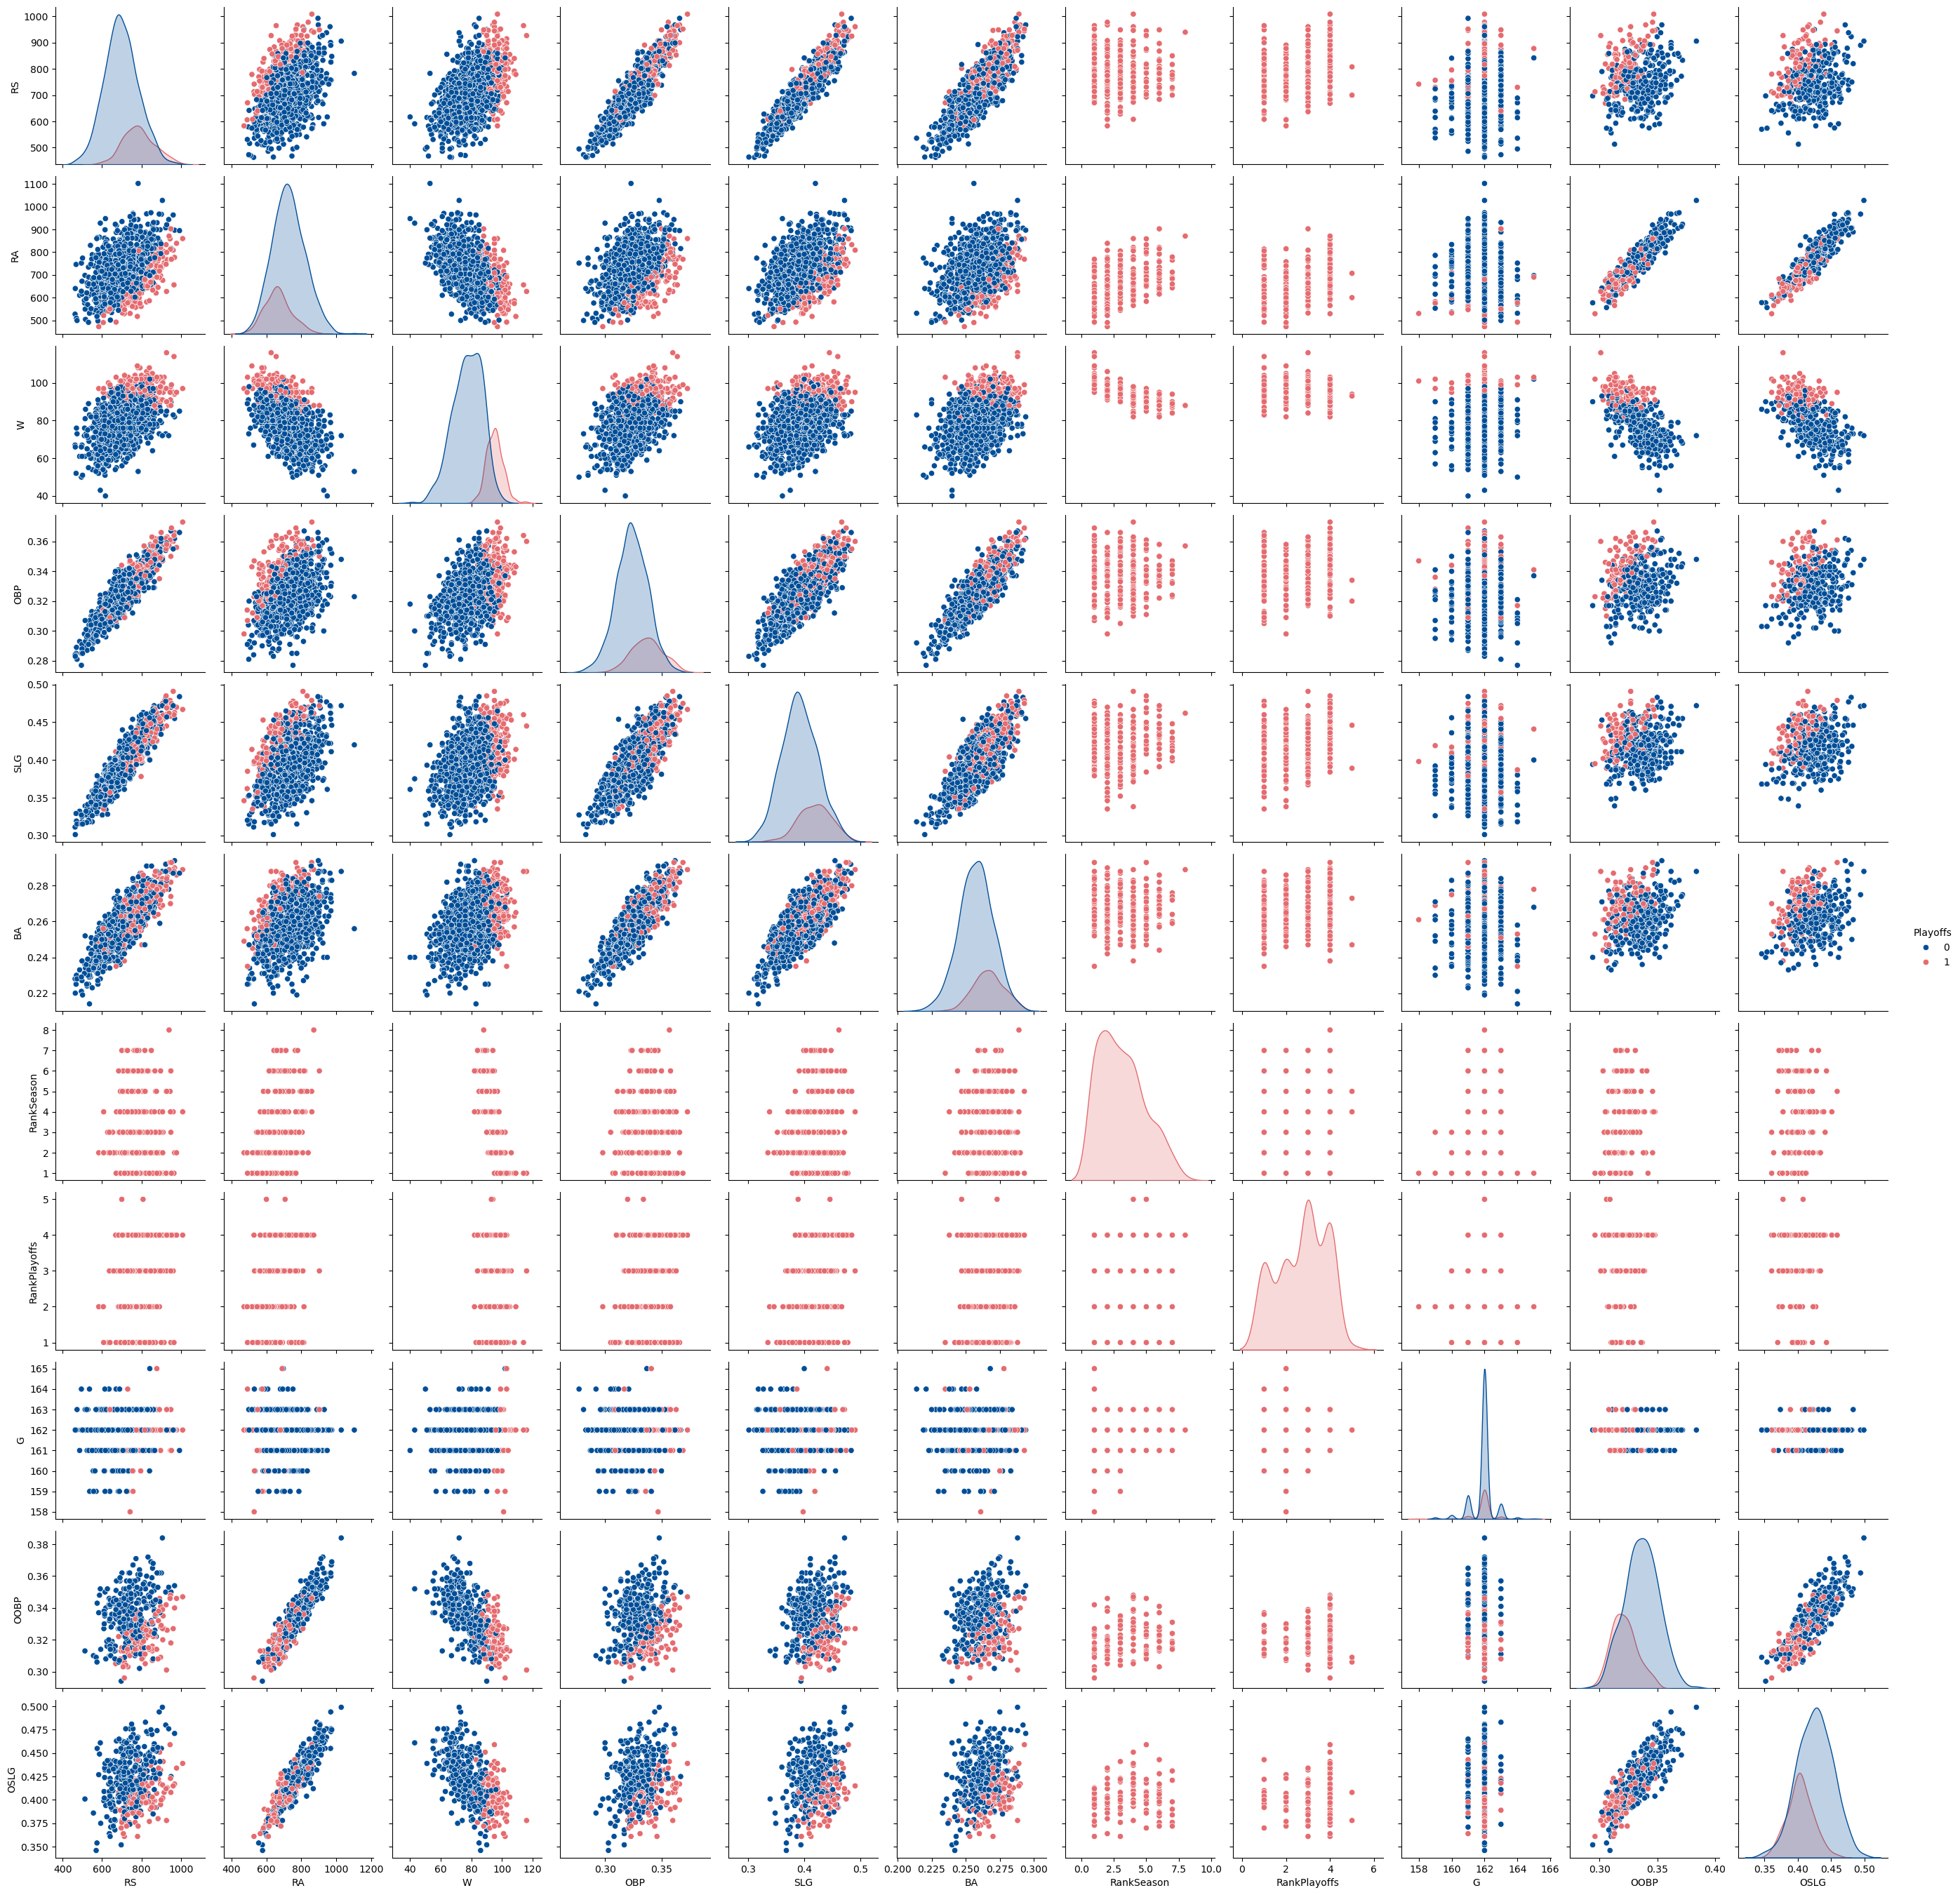

In [15]:
# Drop Team, League and Year before plotting
df_reduced = df.drop(columns=["Team", "League", "Year"])

# Define a custom palette with blue and light red to use in notebook
custom_palette = sns.color_palette(["#004e98", "#e56b6f"])

# Create the pairplot with the remaining columns
sns.pairplot(df_reduced, hue="Playoffs", diag_kind="kde", palette=custom_palette)
plt.show()

#### Comments:
- There are two leagues in the championshis: the National League (NL) and the American League (AL).
- The dataset doesn't have any entries for the years 1972, 1981, 1994 and 1995. This is probably because these were all seasons affected by MLB labor disputes (strikes or lockouts) that led to shortened or canceled games.
- The number of teams that play the championships have increased over time:
  - 20 teams from 1962 to 1968
  - 24 teams from 1969 to 1776
  - 26 teams from 1977 to 1992
  - 28 teams from 1993 to 1997
  - 30 teams from 1998 to 2012
- 39 teams have participated in the championships in this period of time.
- The number of teams that compete in the playoffs has also increased with time: from 2 teams in 1962 to 10 teams in 2012.
- Opponent On-Base Percentage (OOBP) and Opponent Slugging Percentage (OSLG) have about 66% of NaN values. These are all in the rows for years 1962 to 1998, which means that these metrics were not recorded before 1999.
- RankSeason and RankPlayoffs have 988 NaN values and are float objects instead of integer. This number is the same as the 988 teams that did not go to the playoffs. Furthermore, all the graphs in the pairplot that involve these two variables only show orange points. Therefore, RankSeason contains the final ranks of the teams that made it to the playoffs and RankPlayoffs contain the ranks of the teams after completing the playoffs.
- Since the aim of this analysis is to investigate how can a team make it to the playoffs, using RankSeason and RankPlayoffs could lead to data leakage since they only have values when a team has qualified. Therefore they should be dropped from the analysis.

## Part 2. Fitting models.
### Q1. How many games must be won to qualify for playoffs?

In [16]:
# Drop the RankSeason and RankPlayoffs columns to avoid data leakage
df = df.drop(columns=["RankSeason", "RankPlayoffs"])
df.head()

,Team,League,Year,RS,RA,W,OBP,SLG,BA,Playoffs,G,OOBP,OSLG
0,ARI,NL,2012,734,688,81,0.328,0.418,0.259,0,162,0.317,0.415
1,ATL,NL,2012,700,600,94,0.320,0.389,0.247,1,162,0.306,0.378
2,BAL,AL,2012,712,705,93,0.311,0.417,0.247,1,162,0.315,0.403
3,BOS,AL,2012,734,806,69,0.315,0.415,0.260,0,162,0.331,0.428
4,CHC,NL,2012,613,759,61,0.302,0.378,0.240,0,162,0.335,0.424


In [17]:
# Generate new feature: percentage of games won W_perc
df["W_perc"] = df["W"] / df["G"]

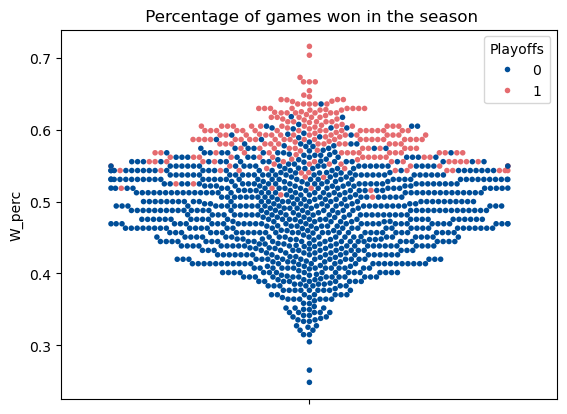

In [18]:
# Making a swarm plot of the percentage of games won
sns.swarmplot(df, y="W_perc", hue="Playoffs", size=4, palette=custom_palette)
plt.title(" Percentage of games won in the season")
plt.show()

#### Comment:
As expected, the swarmplot shows that in general, the teams with the highest percentage of games won made it to the playoffs. 

To determine the minimum amount of games a team should win to make it to the playoffs, a classification model will be fit to the data. 

Since the target variable Playoffs is binary and the feature variable W_perc is numerical continuous, a logistic regression model has been chosen. 

Sample size for both classes is big enough for logistic regression. 

The data has class imbalance in a ratio of approximately 1 to 4 (class 1 to class 0), therefore when creating the logistic regression model the parameters class_weight='balanced' and solver='saga' will be passed . This way the model will automatically adjust weights inversely proportional to class frequencies with a solver that is well suited for imbalanced datasets.

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Prepare the data
X1 = df[["W_perc"]]  # Use percentage of games won as the feature
y1 = df["Playoffs"]  # Target: Whether the team qualified for playoffs

# Split the data into training and testing sets
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, random_state=31)

# Choose and train the model
log_reg = LogisticRegression(class_weight='balanced', solver='saga', max_iter=1000) # model automatically adjusts weights based on class frequencies
                                                                                    # to compensate for class imbalance
log_reg.fit(X1_train, y1_train)

# Make predictions
y1_pred = log_reg.predict(X1_test)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y1_test, y1_pred))

print("\nClassification Report:")
print(classification_report(y1_test, y1_pred))

Confusion Matrix:
[[239  51]
 [  2  78]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.82      0.90       290
           1       0.60      0.97      0.75        80

    accuracy                           0.86       370
   macro avg       0.80      0.90      0.82       370
weighted avg       0.91      0.86      0.87       370



#### Comment:
The model performed well with an accuracy of 86% (total correct predictions). 

Recall and precision of class 0 are quite high (82% and 99%) which means the model is predicting well which teams do not make it to playoffs. 

Recall for class 1 is also high (97%) but has a 60% precision, which means that 40% of the teams predicted as having gone to the playoffs actually didn't. This is why the f1-score of class 1 was 75%.

In order to improve the predictability of class 1, the threshold in the logistic model will be adjusted. Instead of using 0.5, an optimum threshold will be found using precision_recall_curve(). This function returns numpy arrays with recall and precission pairs for various thresholds that can be used to calculate f1 values and determine the highest. New predicted values will be found with the optimum threshold and the model re-evaluated.

In [20]:
# Adjusting decision threshold to improve the predictability of class 1

from sklearn.metrics import precision_recall_curve

# Generate predicted probabilities for class 1
y1_prob = log_reg.predict_proba(X1_test)[:, 1]  # Probabilities for class 1

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y1_test, y1_prob)

# Calculate F1-scores for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)  # Avoid division by zero

# Find the threshold that maximizes the F1-score
best_threshold_index = f1_scores.argmax()   # index of highest f1 value
best_threshold = thresholds[best_threshold_index]
print(f"Best Threshold: {best_threshold:.2f}")
print(f"Best F1-Score: {f1_scores[best_threshold_index]:.2f}")

# Make predictions using the new threshold
y1_pred_new = (y1_prob >= best_threshold).astype(int)

# Evaluate the model with the new threshold
print("Confusion Matrix:")
print(confusion_matrix(y1_test, y1_pred_new))
print("\nClassification Report with New Threshold:")
print(classification_report(y1_test, y1_pred_new))

Best Threshold: 0.52
Best F1-Score: 0.79
Confusion Matrix:
[[253  37]
 [  3  77]]

Classification Report with New Threshold:
              precision    recall  f1-score   support

           0       0.99      0.87      0.93       290
           1       0.68      0.96      0.79        80

    accuracy                           0.89       370
   macro avg       0.83      0.92      0.86       370
weighted avg       0.92      0.89      0.90       370



### Comment:
Adjusting the threshold improved the precission of class 1 to 68% whilst keeping the recall high (96%). The f1 score for class 1 improved by 4 percent points.

Now all is left to do is find the percentage of games won that correspond to the decision point of the model. Given that 162 games are played in the season, it will be possible to determinde the minimum of games that must be won to have a chance of classifying to the playoffs.

The decision point will be shown in a visualization of the decidion boundary for this model.

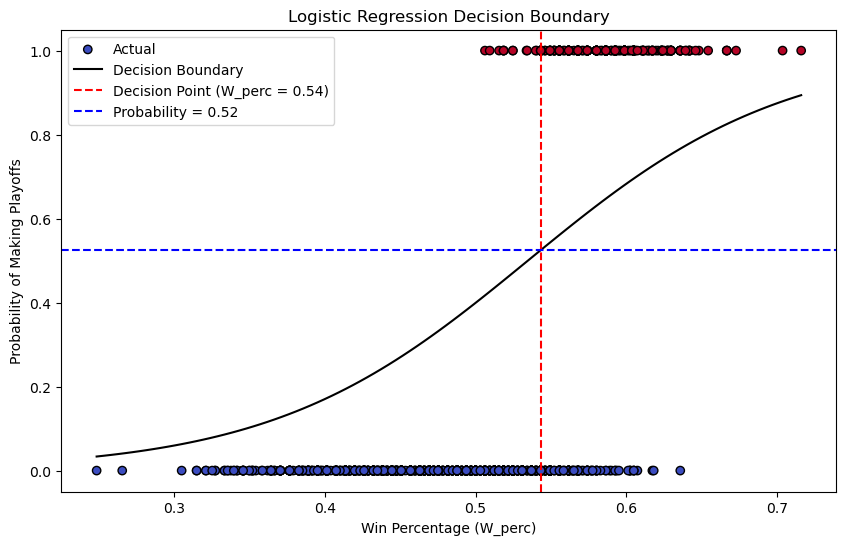

In [21]:
# Visualizing the decision boundary

# Generate a range of W_perc values for plotting
x1_range = np.linspace(X1["W_perc"].min(), X1["W_perc"].max(), 100).reshape(-1, 1)

# Convert x1_range to a DataFrame with the same column name as the training data for feeding to logistic model
x1_range_df = pd.DataFrame(x1_range, columns=["W_perc"])

# Predict probabilities for the range of W_perc values
y1_prob = log_reg.predict_proba(x1_range_df)[:, 1]

# Calculate the decision point (W_perc where probability = best_threshold)
decision_point = (np.log(best_threshold / (1 - best_threshold)) - log_reg.intercept_[0]) / log_reg.coef_[0][0]


# Plot the decision boundary
plt.figure(figsize=(10, 6))
plt.scatter(X1["W_perc"], y1, c=y1, cmap="coolwarm", edgecolors="k", label="Actual")
plt.plot(x1_range, y1_prob, color="black", label="Decision Boundary")


# Add a dotted line at the decision point
plt.axvline(x=decision_point, color="red", linestyle="--", label=f"Decision Point (W_perc = {decision_point:.2f})")
plt.axhline(y=best_threshold, color="blue", linestyle="--", label=f"Probability = {best_threshold:.2f}")

# Add labels and title
plt.xlabel("Win Percentage (W_perc)")
plt.ylabel("Probability of Making Playoffs")
plt.title("Logistic Regression Decision Boundary")
plt.legend()
plt.show()

### Comment:
The minimum percentage of games won to have a chance to qualify for the playoffs is 54%. At 162 games per season, that means a team must win at least 88 games (rounded up from 87.48).

### Q2. What is the required runs difference (runs scored minus runs allowed) to win the required number of games?
To win games is important to score lots of runs whilst at the same time not allowing the opponents to score runs.

In [22]:
# Generate new feature: Runs difference R_diff
df["R_diff"] = df["RS"] - df["RA"]
df.head()

,Team,League,Year,RS,RA,W,OBP,SLG,BA,Playoffs,G,OOBP,OSLG,W_perc,R_diff
0,ARI,NL,2012,734,688,81,0.328,0.418,0.259,0,162,0.317,0.415,0.500000,46
1,ATL,NL,2012,700,600,94,0.320,0.389,0.247,1,162,0.306,0.378,0.580247,100
2,BAL,AL,2012,712,705,93,0.311,0.417,0.247,1,162,0.315,0.403,0.574074,7
3,BOS,AL,2012,734,806,69,0.315,0.415,0.260,0,162,0.331,0.428,0.425926,-72
4,CHC,NL,2012,613,759,61,0.302,0.378,0.240,0,162,0.335,0.424,0.376543,-146


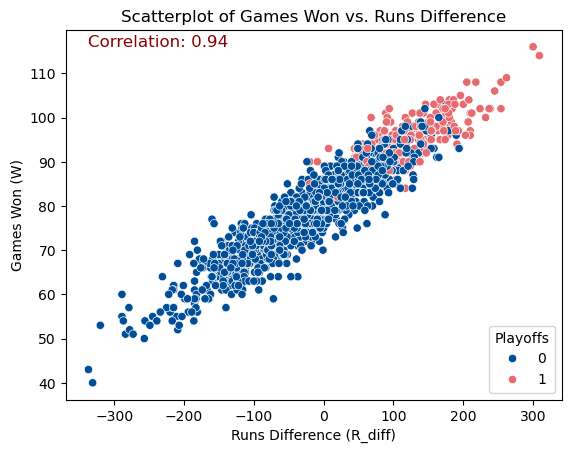

In [23]:
# Investigate relationship between number of games won and runs difference

# Calculate the correlation coefficient
correlation = np.corrcoef(df["R_diff"], df["W"])[0, 1]

sns.scatterplot(df, y = "W", x = "R_diff", hue = "Playoffs", palette=custom_palette) 

# Annotate the correlation coefficient on the plot
plt.text(
    x=df["R_diff"].min(),  # Position on the x-axis
    y=df["W"].max(),       # Position on the y-axis
    s=f"Correlation: {correlation:.2f}",  # Text to display
    fontsize=12,
    color="darkred"
)

# Add labels and title
plt.xlabel("Runs Difference (R_diff)")
plt.ylabel("Games Won (W)")
plt.title("Scatterplot of Games Won vs. Runs Difference")
plt.show()


### Comment:
There is a strong positive correlation between games won and runs difference.

The number of games won is normally distributed as per the pairplot above.

Therefore a linear regression model will be fit to this data.

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error

# Prepare the data

X2 = df[["R_diff"]]
y2 = df[["W"]]

# Split the data into training and testing sets
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state=31)

# Create a model for Linear Regression
lin_reg = LinearRegression()

# Fit the model with the Training data
lin_reg.fit(X2_train,y2_train)

# Calculate the score (R^2 for Regression) for Training Data
print("The R squared score for the training data is: ", lin_reg.score(X2_train,y2_train))

# Calculate the score (R^2 for Regression) for Testing Data
print("The R squared score for the testing data is: ", lin_reg.score(X2_test,y2_test))

# predict values with the model
y2_pred = lin_reg.predict(X2_test)

# calculate the mean squared error, mean absolute error, root mean squared error
mse = mean_squared_error(y2_test, y2_pred)
mae = mean_absolute_error(y2_test,y2_pred)
rmse = root_mean_squared_error(y2_test, y2_pred)
print("Mean squared error: ", mse)
print("Mean absolute error: ", mae)
print("Root mean sq. error: ", rmse)

The R squared score for the training data is:  0.8742812554411614
The R squared score for the testing data is:  0.8877708888537743
Mean squared error:  18.07100932820748
Mean absolute error:  3.356357620094498
Root mean sq. error:  4.251000979558518


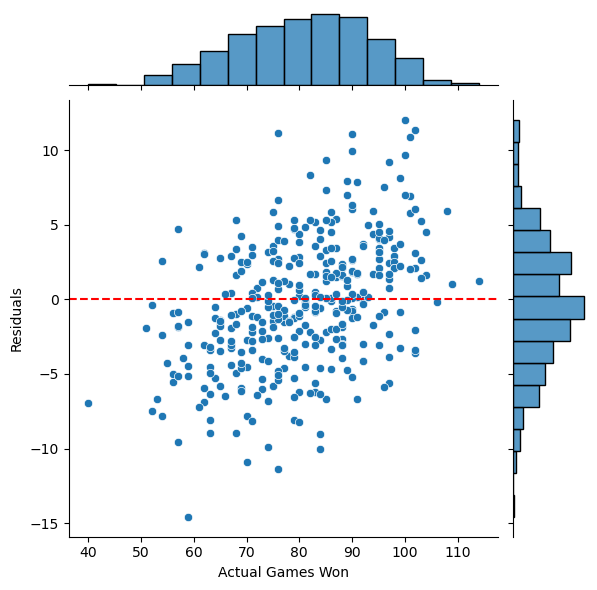

In [25]:
# Verifying that the residuals are normally distributed

residuals = y2_test - y2_pred

# Ensure y2_test and residuals are pandas Series for the jointplot
y2_test_ps = pd.Series(y2_test.squeeze(), name="Actual Games Won")  
residuals_ps = pd.Series(residuals.squeeze(), name="Residuals")     

sns.jointplot(x= y2_test_ps, y= residuals_ps)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Actual Games Won")
plt.ylabel("Residuals")

plt.show()

### Comment:
The R squared value of 0.88 indicates that 88% of the variance in the number of games won is explained by the run differential.

The MSE of 18.1 means that in average the prediction is off by $\sqrt{18.1}$ or 4.25 games. This is a reasonable error given that games won can go from 0 to 162.

The residuals are randomly distributed therfore the model assumptions are valid.

In [26]:
# printing model parameters

intercept = lin_reg.intercept_
gradient = lin_reg.coef_

print("coefficient: ", gradient)
print("intercept: ", intercept)

coefficient:  [[0.10290696]]
intercept:  [80.98928466]


In [27]:
# Using the model to estimate the required run differencial to win 88 games

Required_R_diff = (88 - intercept)/gradient
print("Run differencial to win 88 games: ", Required_R_diff)

Run differencial to win 88 games:  [[68.12673687]]


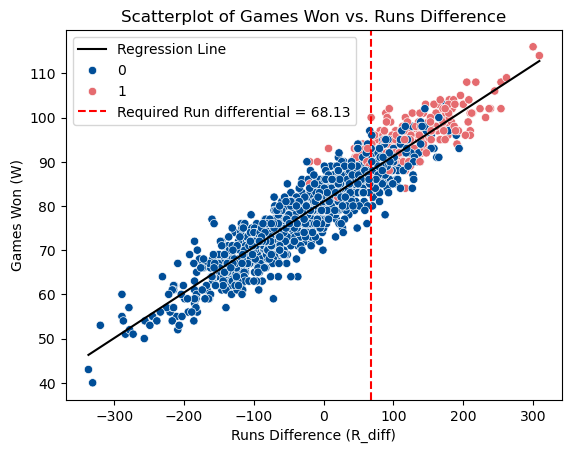

In [28]:
# Checking the required differencial in the scatterplot

# Ensure gradient and intercept are scalars
gradient_scalar = gradient.item() if gradient.size == 1 else gradient[0]
intercept_scalar = intercept.item() if intercept.size == 1 else intercept[0]

# Add the regression line
x_range = np.linspace(df["R_diff"].min(), df["R_diff"].max(), 100)  # Generate x values
y_range = gradient_scalar * x_range + intercept_scalar  # Calculate corresponding y values
plt.plot(x_range, y_range, color="black", label="Regression Line")  # Plot the regression line

# Create the scatterplot
sns.scatterplot(
    data=df,
    y="W",
    x="R_diff",
    hue="Playoffs",
    palette=custom_palette,
)

# Add vertical line for required run differencial
Required_R_diff_scalar = Required_R_diff.item() if Required_R_diff.size == 1 else Required_R_diff[0]  # to ensure is a scalar
plt.axvline(x=Required_R_diff_scalar, color="red", linestyle="--", label=f"Required Run differential = {Required_R_diff_scalar:.2f}")

# Add labels and title
plt.xlabel("Runs Difference (R_diff)")
plt.ylabel("Games Won (W)")
plt.title("Scatterplot of Games Won vs. Runs Difference")
plt.legend()
plt.show()

### Comment:
To win the required 88 games to have a chance to go to the playoffs, a team must score 69 runs (rounded up) more than the runs it allows. This is only an estimate and does not guarrantee a pass to the playoffs, since there are quite a few teams that have run differencials bigger than this and have not made it, as shown in the graph above. Teams should probably aim to have a differencial closer to 100 to increase their chances.

### Q3. How does a team achieves this run difference?
To score runs, teams need to have players who can make solid contact, hit for power, and get on base consistently through walks and hits. To stop opponents from scoring, a team needs effective pitching, solid defense, and good game strategy.

A linear regression model will be fitted with the features that relate to player performance: batting average (BA), on base percentage (OBP), slugging percentage (SLG), opponent on-base percentage (OOBP) and opponent slugging percentage (OSLG).

The NaN values in these last two features need to be replaced with suitable values before fitting the model. 

In [29]:
# fill missing values with team averages
df["OOBP"] = df.groupby("Team")["OOBP"].transform(lambda x: x.fillna(x.mean()))
df["OSLG"] = df.groupby("Team")["OSLG"].transform(lambda x: x.fillna(x.mean()))

In [30]:
df.isnull().sum()

Team         0
League       0
Year         0
RS           0
RA           0
W            0
OBP          0
SLG          0
BA           0
Playoffs     0
G            0
OOBP        49
OSLG        49
W_perc       0
R_diff       0
dtype: int64

In [31]:
# fill remaining missing values with year averages
df["OOBP"] = df.groupby("Year")["OOBP"].transform(lambda x: x.fillna(x.mean()))
df["OSLG"] = df.groupby("Year")["OSLG"].transform(lambda x: x.fillna(x.mean()))

In [32]:
df.isnull().sum()

Team        0
League      0
Year        0
RS          0
RA          0
W           0
OBP         0
SLG         0
BA          0
Playoffs    0
G           0
OOBP        0
OSLG        0
W_perc      0
R_diff      0
dtype: int64

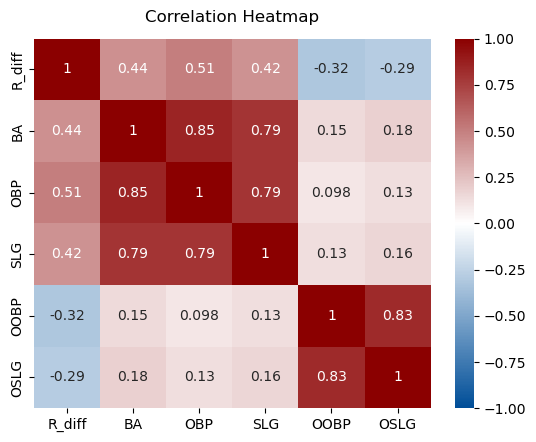

In [33]:
# Checking correlation between R_diff and BA, OBP, SLG, OOBP and OSLG 
from matplotlib.colors import LinearSegmentedColormap

corr = df.loc[:,['R_diff','BA','OBP','SLG', 'OOBP', 'OSLG']].corr()

# Correlation heatmap
custom_cmap = LinearSegmentedColormap.from_list(None, ["#004e98", "white", "darkred"]) # define custom colormap

heatmap = sns.heatmap(corr, vmin=-1, vmax=1, cmap=custom_cmap, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)
plt.show()

### Comment:
The correlation matrix doesn't show strong correlations between R_diff and the feature variables. The strongest correlation is 0.51 with OBP. As expected OOBP and OSLG show negative correlation with R_diff since they are performance metrix for the opposing team. BA has strong positive correlation with OBP (0.85), and OOBP has strong positive correlation with OSLG (0.83). Still, the model will be fit with all 5 features.

In [34]:
X3 = df[['BA','OBP','SLG', 'OOBP', 'OSLG']]
y3 = df[['R_diff']]

In [35]:
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.3, random_state=31)  # Train-Test Split

lin_reg2 = LinearRegression(fit_intercept=True)  # Create a model for Linear Regression
lin_reg2.fit(X3_train,y3_train)  # Fit the model with the Training data

# Calculate the score (R^2 for Regression) for Training Data
print("The R squared score for the training data is: ", lin_reg2.score(X3_train,y3_train))

# Calculate the score (R^2 for Regression) for Testing Data
print("The R squared score for the testing data is: ", lin_reg2.score(X3_test,y3_test))

# predict values with the model
y3_pred = lin_reg2.predict(X3_test)

# calculate the mean squared error, mean absolute error, root mean squared error
mse = mean_squared_error(y3_test, y3_pred)
mae = mean_absolute_error(y3_test,y3_pred)
rmse = root_mean_squared_error(y3_test, y3_pred)
print("Mean squared error: ", mse)
print("Mean absolute error: ", mae)
print("Root mean sq. error: ", rmse)

The R squared score for the training data is:  0.40649626388674853
The R squared score for the testing data is:  0.40510633141117847
Mean squared error:  7371.198513298254
Mean absolute error:  69.26168492653136
Root mean sq. error:  85.85568422241042


In [36]:
# Get the feature names (columns of X3_train)
feature_names = X3_train.columns

# Get the coefficients from the Lasso model
coefficients = lin_reg2.coef_.flatten()

print("Model's coefficients:")
# Print each feature name with its corresponding coefficient
for feature, coef in zip(feature_names, coefficients):
    print(f"{feature}: {coef}")

print("intercept: ", lin_reg2.intercept_)

Model's coefficients:
BA: -33.21272940796096
OBP: 3058.404797159456
SLG: 370.4550729331356
OOBP: -2294.337810737113
OSLG: -786.0395836364761
intercept:  [-45.91184706]


### Comment:
The model is performing poorly since it is only predicting about 41% of the target vaiable's variance. 

The MSE is 7371, which means it is off by about 86 runs. Given that the run differencial ranges between -300 and 300 runs, the error is too big. 

Given there is high multicollinearity among BA, OBP, and SLG it is difficult for the model to determine the individual effect of each feature. 

Inspecting the coefficients, the features with the greatest influence on run differential were OBP and OOBP. However, due to the model’s poor overall performance, these results should be interpreted with caution.

Forward feature selection can be implemented to decide wich features to keep.

In [37]:
# Try using forward feature selection

show_steps = False   # without showing steps

## Use Forward Feature Selection to pick a good model

# start with no predictors
included = []
# keep track of model and parameters
best = {'feature': '', 'r2': 0, 'a_r2': 0}
# create a model object to hold the modelling parameters
model = LinearRegression()
# get the number of cases in the training data
n = X3_train.shape[0]

r2_list = []
adjusted_r2_list = []


while True:
    changed = False

    if show_steps:
        print('')

    # list the features to be evaluated
    excluded = list(set(X3.columns) - set(included))

    if show_steps:
        print(f"(Step) Excluded = {', '.join(excluded)}")

    # for each remaining feature to be evaluated
    for new_column in excluded:

        if show_steps:
            print(f"(Step) Trying {new_column}...")
            print(f"(Step) - Features = {', '.join(included + [new_column])}")

        # fit the model with the Training data
        fit = model.fit(X3_train[included + [new_column]], y3_train) # fit a model; uses included features plus one more
        # calculate the score (R^2 for Regression)
        r2 = model.score(X3_train[included + [new_column]], y3_train) # calculate the score
        # number of predictors in this model
        k = len(included) + 1
        # calculate the adjusted R^2
        adjusted_r2 = 1 - (1 - r2)*(n - 1)/(n - k - 1) # calculate the Adjusted R^2

        if show_steps:
            print(f"(Step) - Adjusted R^2: This = {adjusted_r2:.3f}; Best = {best['a_r2']:.3f}")

        # if model improves
        if adjusted_r2 > best['a_r2']:
            # record new parameters
            best = {'feature': new_column, 'r2': r2, 'a_r2': adjusted_r2}
            # flag that found a better model
            changed = True
            if show_steps:
                print(f"(Step) - New Best!   : Feature = {best['feature']}; R^2 = {best['r2']:.3f}; Adjusted R^2 = {best['a_r2']:.3f}")
    # END for

    # if found a better model after testing all remaining features
    if changed:
        # update control details
        included.append(best['feature'])
        excluded = list(set(excluded) - set(best['feature']))
        print(f"Added feature {best['feature']} with R^2 = {best['r2']:.3f} and adjusted R^2 = {best['a_r2']:.3f}")

        # record the r2 and adjusted r2 values
        r2_list.append(best['r2'])
        adjusted_r2_list.append(best['a_r2'])
    else:
        # terminate if no better model
        break

print('')
print('Resulting features:')
print(', '.join(included))

Added feature OBP with R^2 = 0.254 and adjusted R^2 = 0.253
Added feature OOBP with R^2 = 0.394 and adjusted R^2 = 0.392
Added feature OSLG with R^2 = 0.401 and adjusted R^2 = 0.399
Added feature SLG with R^2 = 0.406 and adjusted R^2 = 0.404

Resulting features:
OBP, OOBP, OSLG, SLG


### Comment:
Dropping the batting average does not affect the model performance much, but it does make it simpler. Let's inspect the features further

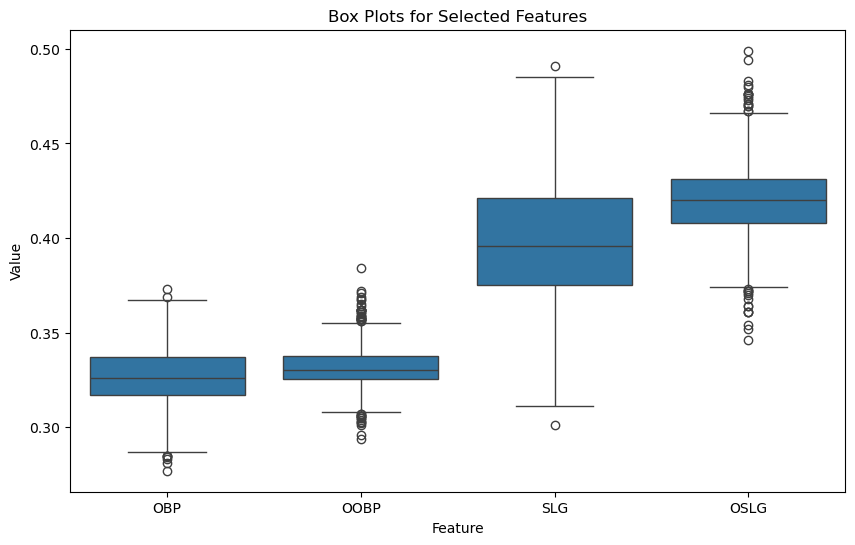

In [38]:

# Select the best features
best_features = ['OBP', 'OOBP', 'SLG', 'OSLG']

# Melt the DataFrame to long format for easier plotting
df_melted = df[best_features].melt(var_name="Feature", value_name="Value")

# Create box plots for the selected features
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_melted, x="Feature", y="Value")
plt.title("Box Plots for Selected Features")
plt.xlabel("Feature")
plt.ylabel("Value")
plt.show()



### Comment:
Three of the four features show outliers. These affect regression models because they are fit by minimizing the sum of squared residuals. 

In [39]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df[['OBP', 'OOBP', 'SLG', 'OSLG']]
vif = pd.DataFrame()
vif["Feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

  Feature          VIF
0     OBP   916.981456
1    OOBP  1920.552735
2     SLG   359.338820
3    OSLG  1437.941199


### Comment:
A Variance Inflation Factor (VIF) bigger than 10 indicates high multicollinearity. As shown above all 4 features have very high VIF.

In summary, fitting a linear regression model to predict R_diff based on the chosen features is not recommended since the highest score obtained for the model was 0.404. The main problems of the model were multicollinearity and outliers.

There are many statistics in baseball, and there might be some that correlate better with the target variable.